In [240]:
import sys
sys.path.append('..')
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.getcwd()
from gax import sersic
from gax.sersic import sersic_2d_linear_pix
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import astropy
import numpy as np
from astropy.table import Table, vstack
import gax_fits as gfits
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator

bands = np.array(['U','G','R','I','Z'])
wavs = np.array([354.3e-9, 477.0e-9, 623.1e-9, 762.5e-9, 913.4e-9], dtype=float)



In [267]:
# Original Images

M51_B             = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/Cleaned/M_51_B_KPNO.fits')         #4400 Å
M51_B_Table       = gfits.Read_Table('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_B_KPNO/0200/source_params.fits')         #4400 Å

M51_B = M51_B.byteswap().newbyteorder('L')


M51_R             = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/Cleaned/M_51_R_KPNO.fits')         #4400 Å
M51_R_Table       = gfits.Read_Table('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_R_KPNO/0200/source_params.fits')         #4400 Å

M51_R = M51_R.byteswap().newbyteorder('L')

M51_V             = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/Cleaned/M_51_V_KPNO.fits')         #5500 Å
M51_V_Table       = gfits.Read_Table('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_V_KPNO/0200/source_params.fits')         #4400 Å

M51_V = M51_V.byteswap().newbyteorder('L')

In [268]:
# FICL Processed Images
M51_B_I = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_B_KPNO/0200/small_nonpar.fits')
M51_R_I = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_R_KPNO/0200/small_nonpar.fits')
M51_V_I = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_V_KPNO/0200/small_nonpar.fits')

In [374]:
# Fix Images

M51_B -= 1000
M51_R -= 1000
M51_V -= 1000
# Calibrate Flux
# units -> JY*SEC/DN/PIXEL
exp_time_B = 720
Jansky_conv_B = 1.5668e-06
zero_point_B = 4270 # Janskys

exp_time_R = 720
Jansky_conv_R = 1.16999e-06
zero_point_R = 3670


exp_time_V = 320
Jansky_conv_V = 8.17556e-07
zero_point_V = 2840


M51_B = ((M51_B/exp_time_B)/Jansky_conv_B)/zero_point_B
M51_V = ((M51_V/exp_time_V)/Jansky_conv_V)/zero_point_V
M51_R = ((M51_R/exp_time_R)/Jansky_conv_R)/zero_point_R

M51_B_I = ((M51_B_I/exp_time_B)/Jansky_conv_B)/zero_point_B
M51_V_I = ((M51_V_I/exp_time_V)/Jansky_conv_V)/zero_point_V
M51_R_I = ((M51_R_I/exp_time_R)/Jansky_conv_R)/zero_point_R


M51_B,M51_V,M51_R

(array([[ 0.        ,  0.        ,  0.        , ..., -0.006114  ,
         -0.00653226, -0.00499859],
        [ 0.        ,  0.        ,  0.        , ..., -0.00623005,
         -0.00665096, -0.00657309],
        [ 0.        ,  0.        ,  0.        , ..., -0.00479573,
         -0.00492484, -0.00595062],
        ...,
        [ 0.        ,  0.00318803,  0.00189946, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00106042, -0.00031189, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.00082731, -0.00170051, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ,  0.        , ..., -0.06070612,
         -0.04511904, -0.01599666],
        [ 0.        ,  0.        ,  0.        , ..., -0.05993065,
         -0.05014416, -0.0308977 ],
        [ 0.        ,  0.        ,  0.        , ..., -0.0455066 ,
         -0.05414816, -0.05367607],
        ...,
        [ 0.        , -0.03316902, -0.02659575, ...,  

In [375]:
def max_I_pos(image):
    bulge_intensity = np.nanmax(image)
    bulge_pos = np.asarray(np.argwhere(image == bulge_intensity))
    return bulge_pos.ravel()[::-1]

# Make a quick image show function

def show(image,range=(0.5,99.5)):
    minI,maxI = np.percentile(image,range)
    plt.imshow(image,vmin=minI,vmax=maxI)


x_B,y_B = max_I_pos(M51_B)

# Ammend table with bulge pos
height,width = M51_B.shape

# Image centre relative coords
x_B_rel = x_B - width/2
y_B_rel = y_B - height/2

# Set the table coords
M51_B_Table['x'] = x_B_rel
M51_B_Table['y'] = y_B_rel


In [376]:

inner_stable = 0.325
outer_stable = 0.9

Test_Image = M51_B
Test_Table = M51_B_Table

# Generate a set of spiral points using the information
# Going to try with a Boolean array instead
# Get image info:
height, width = Test_Image.shape[:2]   

R_e = 10**Test_Table['log_re']
x_centre = int(Test_Table['x'] + width/2)
y_centre = int(Test_Table['y'] + height/2)

# Create Polar Spiral
#A_p_max = A_p_m[np.argmax(A_p_m)]
argument = np.radians(-25)#np.angle(A_p_max)#np.radians(35)
#print(argument)
argument_2 = np.radians(np.degrees(argument)+180)
r_0 = 1                                     # Scale 1:1 pix
theta = np.linspace(2*np.pi,8*(np.pi),3600)
phi = -16.8#-14.560275619356032 #np.degrees(np.arctan((0-m)/p_max))


#===================================================================
# Add uncertainty curves 
phi_ERR = 4.8

r_low = r_0 *np.exp(theta*np.abs(np.tan(np.radians(phi-phi_ERR)))) 
r_high = r_0 *np.exp(theta*np.abs(np.tan(np.radians(phi+phi_ERR)))) 

x = r_low*np.cos(theta)
y = r_low*np.sin(theta) 
vector_low = np.stack([x,y],axis=1).T

x = r_high*np.cos(theta)
y = r_high*np.sin(theta) 
vector_high = np.stack([x,y],axis=1).T

rot_mat = np.array([[np.cos(argument),-np.sin(argument)],
                [np.sin(argument), np.cos(argument)]])

rot_mat_2 = np.array([[np.cos(argument_2),-np.sin(argument_2)],
                [np.sin(argument_2), np.cos(argument_2)]])

rotated_vector_low = rot_mat @ vector_low
rotated_vector_2_low = rot_mat_2 @ vector_low

x_low = rotated_vector_low[0] #+ x_centre
y_low = rotated_vector_low[1] #+ y_centre

x_2low = rotated_vector_2_low[0] #+ x_centre
y_2low = rotated_vector_2_low[1] #+ y_centre

rotated_vector_high = rot_mat @ vector_high
rotated_vector_2_high = rot_mat_2 @ vector_high

x_high = rotated_vector_high[0] #+ x_centre
y_high = rotated_vector_high[1] #+ y_centre

x_2high = rotated_vector_2_high[0] #+ x_centre
y_2high = rotated_vector_2_high[1] #+ y_centre


#===================================================================

r = r_0 *np.exp(theta*np.abs(np.tan(np.radians(phi)))) 

# Convert to Cartesian
x = r*np.cos(theta)
y = r*np.sin(theta) 
vector = np.stack([x,y],axis=1).T

rot_mat = np.array([[np.cos(argument),-np.sin(argument)],
                [np.sin(argument), np.cos(argument)]])

rot_mat_2 = np.array([[np.cos(argument_2),-np.sin(argument_2)],
                [np.sin(argument_2), np.cos(argument_2)]])

rotated_vector = rot_mat @ vector
rotated_vector_2 = rot_mat_2 @ vector

x_ = rotated_vector[0] #+ x_centre
y_ = rotated_vector[1] #+ y_centre

x_2 = rotated_vector_2[0] #+ x_centre
y_2 = rotated_vector_2[1] #+ y_centre

range_min = inner_stable * R_e
range_max = outer_stable * R_e

# Create a boolean mask to filter out points outside the range
mask = (np.sqrt(x_**2 + y_**2) >= range_min) & (np.sqrt(x_**2 + y_**2) <= range_max)
masklow = (np.sqrt(x_low**2 + y_low**2) >= range_min) & (np.sqrt(x_low**2 + y_low**2) <= range_max)
maskhigh = (np.sqrt(x_high**2 + y_high**2) >= range_min) & (np.sqrt(x_high**2 + y_high**2) <= range_max)

# Apply the mask to the data
x_trimmed = x_[mask] + x_centre
y_trimmed = -1*(y_[mask]) + y_centre

x_2_trimmed = x_2[mask] + x_centre
y_2_trimmed = -1*(y_2[mask]) + y_centre

# Low
#=====

x_trimmedlow = x_low[masklow] + x_centre
y_trimmedlow = -1*(y_low[masklow]) + y_centre

x_2_trimmedlow = x_2low[masklow] + x_centre
y_2_trimmedlow = -1*(y_2low[masklow]) + y_centre

# High
#======

x_trimmedhigh = x_high[maskhigh] + x_centre
y_trimmedhigh = -1*(y_high[maskhigh]) + y_centre

x_2_trimmedhigh = x_2high[maskhigh] + x_centre
y_2_trimmedhigh = -1*(y_2high[maskhigh]) + y_centre


spiral_1_points = np.vstack([x_trimmed,y_trimmed]).T

In [377]:
# let's put some fake data on to show us where we are sampling from
#for i in range (0,M51_B.shape[1]-200):
    #M51_B[i+300,i]=1020.0
    #M51_B[i+50,i]=920.0
    #M51_B[i,i+50]=997.0
    #M51_B[i+420,i+51]=1081.0
    #M51_B[M51_B.shape[1]-i,i]=1018.0
#this shows up correctly
#show(M51_B)

In [378]:
normals_B_1 = gfits.Spiral_normal_distributions(M51_B,M51_B_Table,spiral_1_points,
                                                int(len(spiral_1_points)/2),200,False,False)

normals_V_1 = gfits.Spiral_normal_distributions(M51_V,M51_R_Table,spiral_1_points,
                                                int(len(spiral_1_points)/2),200,False,False)

normals_R_1 = gfits.Spiral_normal_distributions(M51_R,M51_R_Table,spiral_1_points,
                                                int(len(spiral_1_points)/2),200,False,False)

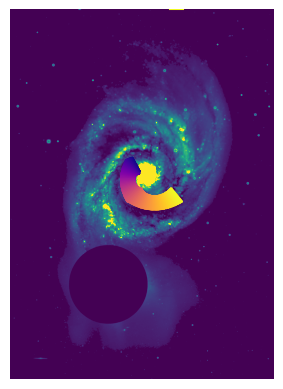

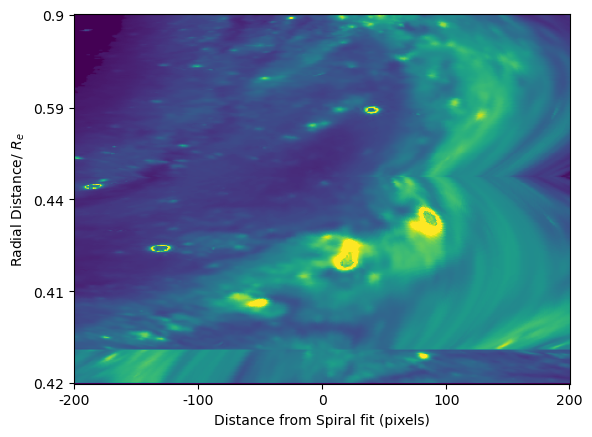

In [379]:
normals_B_I_1 = gfits.Spiral_normal_distributions(M51_B_I,M51_B_Table,spiral_1_points,
                                                int(len(spiral_1_points)/2),200,False,False)

normals_V_I_1 = gfits.Spiral_normal_distributions(M51_V_I,M51_R_Table,spiral_1_points,
                                                int(len(spiral_1_points)/2),200,True,False)

normals_R_I_1 = gfits.Spiral_normal_distributions(M51_R_I,M51_R_Table,spiral_1_points,
                                                int(len(spiral_1_points)/2),200,False,False)

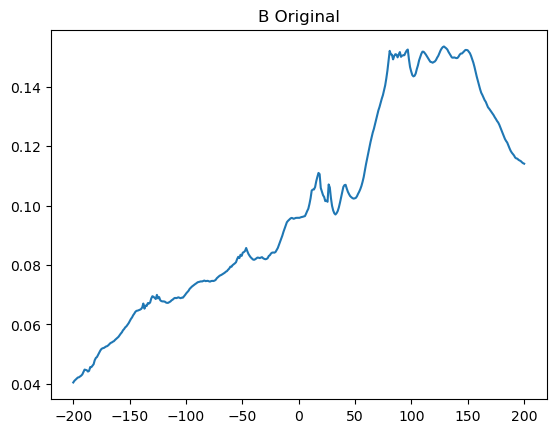

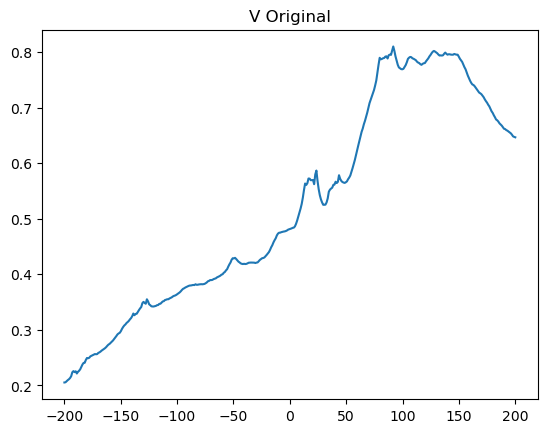

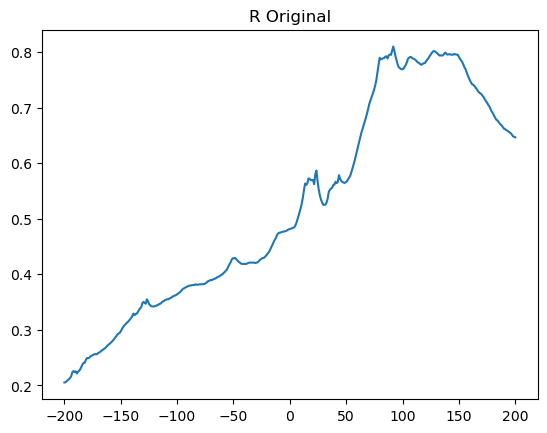

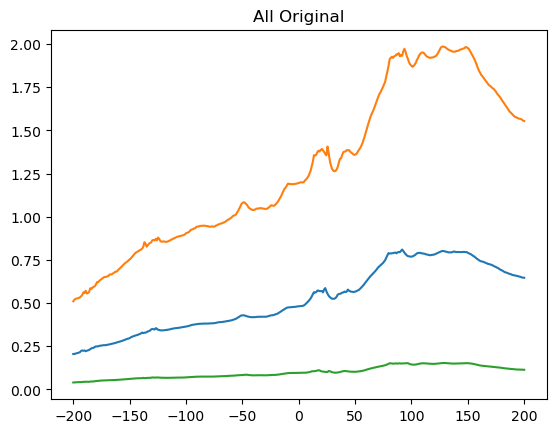

In [380]:
intensity_B = np.average(normals_B_1,axis=0)
distance = np.linspace(-200,200,len(intensity_B))
#show(normals_B_1)
plt.figure()
plt.title('B Original')
plt.plot(distance,intensity_B)

intensity_V = np.average(normals_V_1,axis=0)
#show(normals_R_1)
plt.figure()
plt.title('V Original')
plt.plot(distance,intensity_R)

intensity_R = np.average(normals_R_1,axis=0)
#show(normals_R_1)
plt.figure()
plt.title('R Original')
plt.plot(distance,intensity_R)

plt.figure()
plt.title('All Original')
plt.plot(distance,intensity_R)
plt.plot(distance,intensity_V)
plt.plot(distance,intensity_B)

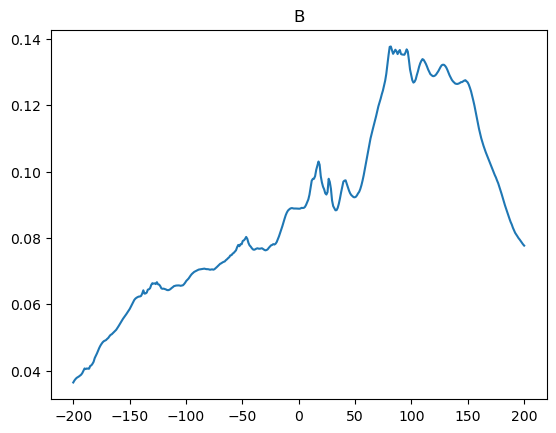

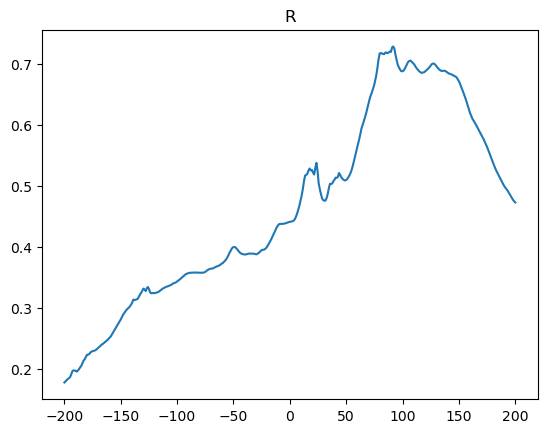

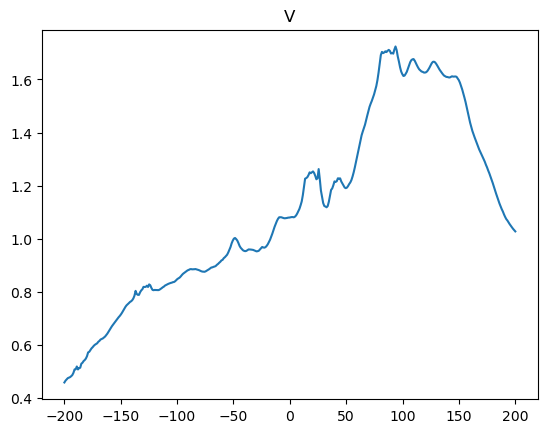

In [381]:
intensity_B_I = np.average(normals_B_I_1,axis=0)
distance = np.linspace(-200,200,len(intensity_B_I))
#show(normals_B_1)
plt.figure()
plt.title('B')
plt.plot(distance,intensity_B_I)

intensity_R_I = np.average(normals_R_I_1,axis=0)
#show(normals_R_1)
plt.figure()
plt.title('R')
plt.plot(distance,intensity_R_I)
intensity_V_I = np.average(normals_V_I_1,axis=0)

#show(normals_V_1)
plt.figure()
plt.title('V')
plt.plot(distance,intensity_V_I)

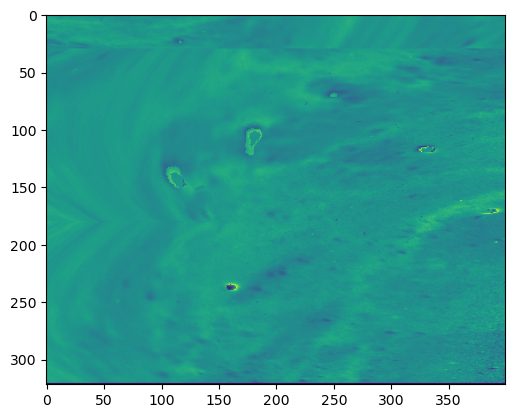

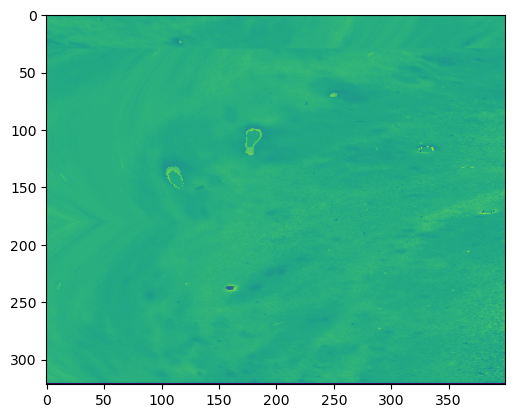

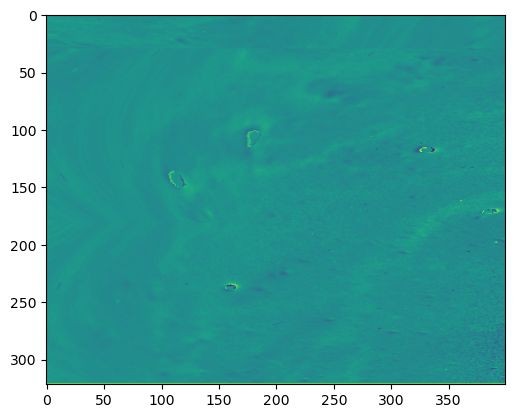

In [382]:
normals_B_I_1 += 1e-10
normals_R_I_1 += 1e-10
normals_V_I_1 += 1e-10

normals_B_1 += 1e-10
normals_R_1 += 1e-10
normals_V_1 += 1e-10

B_R_Colour = np.fliplr(-2.5*np.log10((normals_B_1/normals_R_1)))
B_V_Colour = np.fliplr(-2.5*np.log10((normals_B_1/normals_V_1)))
V_R_Colour = np.fliplr(-2.5*np.log10((normals_V_1/normals_R_1)))

plt.figure()
plt.imshow(B_R_Colour)
plt.figure()
plt.imshow(B_V_Colour)
plt.figure()
plt.imshow(V_R_Colour)

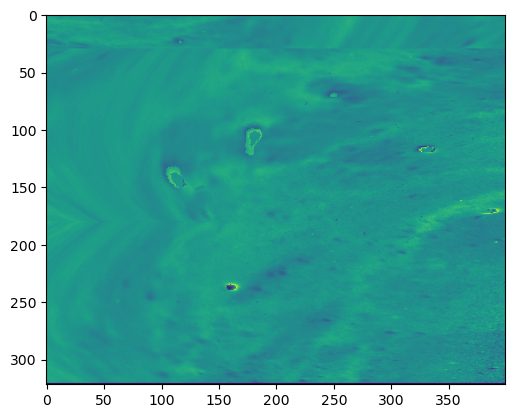

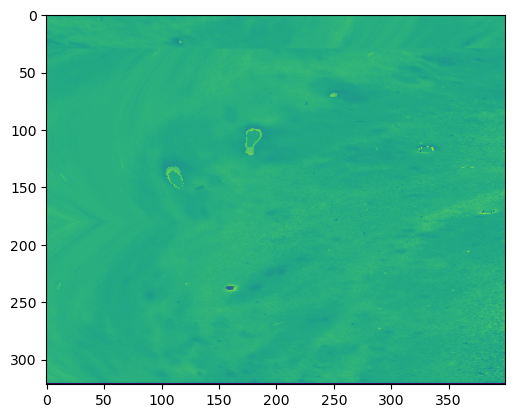

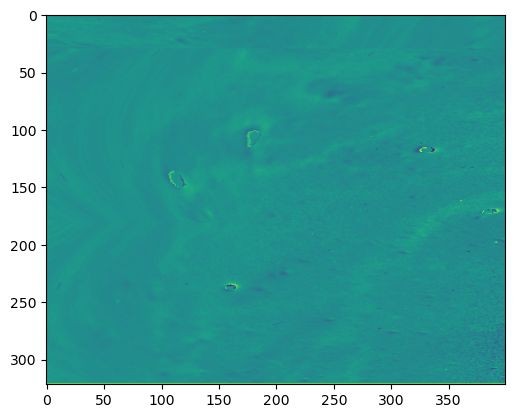

In [383]:
B_R_Colour_I_1 = np.fliplr(-2.5*np.log10((normals_B_I_1/normals_R_I_1)))
B_V_Colour_I_1 = np.fliplr(-2.5*np.log10((normals_B_I_1/normals_V_I_1)))
V_R_Colour_I_1 = np.fliplr(-2.5*np.log10((normals_V_I_1/normals_R_I_1)))

plt.figure()
plt.imshow(B_R_Colour)
plt.figure()
plt.imshow(B_V_Colour)
plt.figure()
plt.imshow(V_R_Colour)

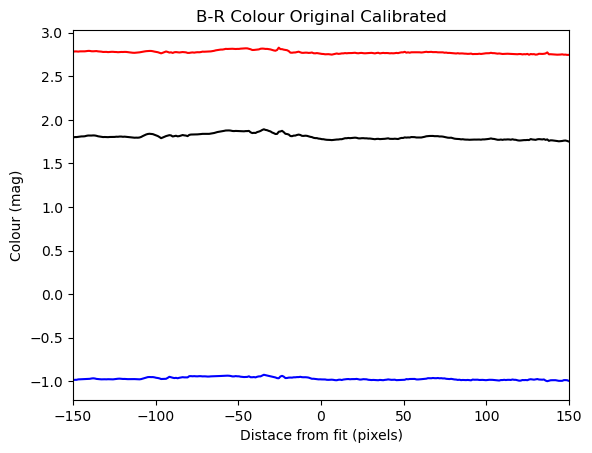

In [384]:
#args =np.argwhere(B_R_Colour == np.nan)


avg_intensity_BR = np.average(B_R_Colour[1:,:],axis=0)
uncertainty_BR = np.std(B_R_Colour[1:,:],axis=0)/ np.sqrt(B_R_Colour[1:,:].shape[0])

avg_intensity_BV = np.average(B_V_Colour[1:,:],axis=0)
uncertainty_BV = np.std(B_V_Colour[1:,:],axis=0)/ np.sqrt(B_V_Colour[1:,:].shape[0])

avg_intensity_VR = np.average(V_R_Colour[1:,:],axis=0)
uncertainty_VR = np.std(V_R_Colour[1:,:],axis=0)/ np.sqrt(V_R_Colour[1:,:].shape[0])

plt.figure()
plt.title('B-R Colour Original Calibrated')
plt.ylabel('Colour (mag)')
plt.xlabel('Distace from fit (pixels)')
plt.xlim(-150,150)
plt.plot(distance,avg_intensity_BR,'k')
plt.plot(distance,avg_intensity_BV,'r')
plt.plot(distance,avg_intensity_VR,'b')
#plt.fill_between(distance,avg_intensity-uncertainty,
                 #avg_intensity+uncertainty,alpha=0.2,color='red')


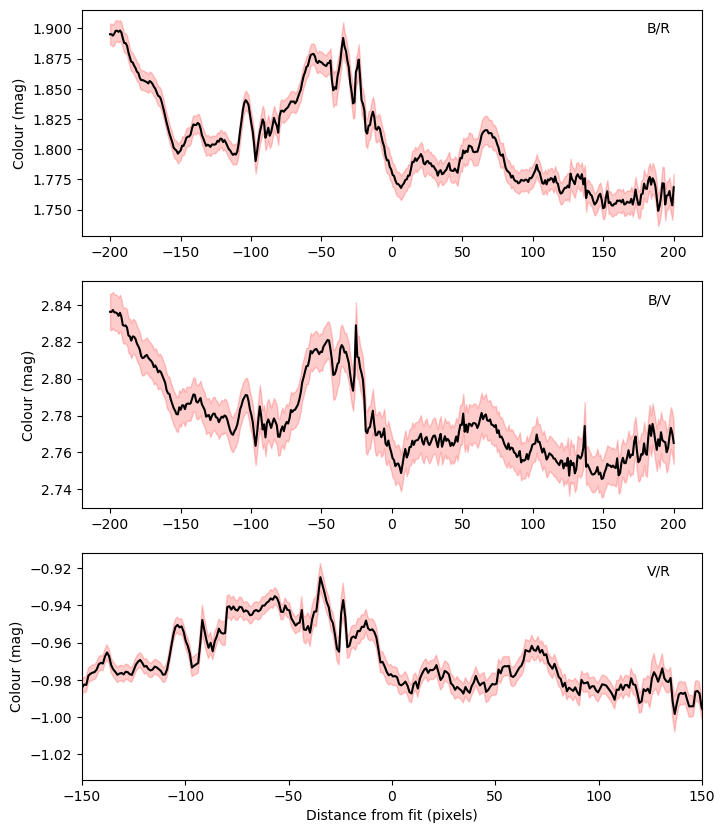

In [385]:
# Original

fig, axs = plt.subplots(3, 1, figsize=(8, 10))#, sharex=True)

# First subplot - B-R Colour Original Calibrated
#axs[0].set_title('B-R Colour Original Calibrated')
axs[0].set_ylabel('Colour (mag)')
axs[0].plot(distance, avg_intensity_BR, 'k')
axs[0].fill_between(distance,avg_intensity_BR-uncertainty_BR,
                 avg_intensity_BR+uncertainty_BR,alpha=0.2,color='red')
axs[0].text(0.95, 0.95, 'B/R', ha='right', va='top', transform=axs[0].transAxes)


# Second subplot - B-V Colour Original Calibrated
axs[1].set_ylabel('Colour (mag)')
axs[1].plot(distance, avg_intensity_BV, 'k')
axs[1].fill_between(distance,avg_intensity_BV-uncertainty_BV,
                 avg_intensity_BV+uncertainty_BV,alpha=0.2,color='red')
axs[1].text(0.95, 0.95, 'B/V', ha='right', va='top', transform=axs[1].transAxes)

# Third subplot - V-R Colour Original Calibrated
axs[2].set_xlabel('Distance from fit (pixels)')
axs[2].set_ylabel('Colour (mag)')
axs[2].plot(distance, avg_intensity_VR, 'k')
axs[2].fill_between(distance,avg_intensity_VR-uncertainty_VR,
                 avg_intensity_VR+uncertainty_VR,alpha=0.2,color='red')
axs[2].text(0.95, 0.95, 'V/R', ha='right', va='top', transform=axs[2].transAxes)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2)

plt.xlim(-150, 150)

plt.show()


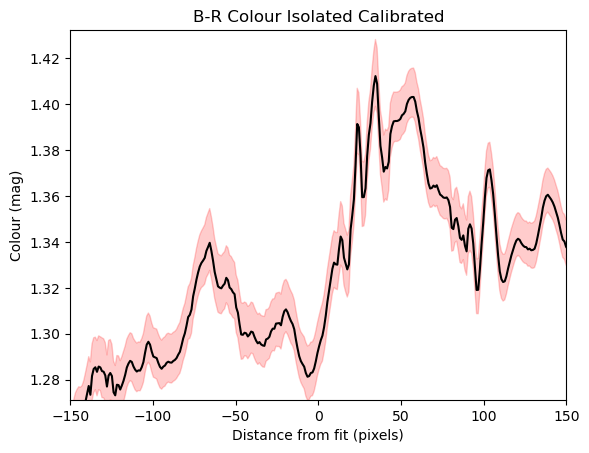

In [386]:
args =np.argwhere(B_R_Colour == np.nan)
avg_intensity_BR_I = np.average(B_R_Colour_I_1[1:,:],axis=0)
uncertainty_BR_I = np.std(B_R_Colour_I_1[1:,:],axis=0)/ np.sqrt(B_R_Colour[1:,:].shape[0])

avg_intensity_BV_I = np.average(B_V_Colour_I_1[1:,:],axis=0)
uncertainty_BV_I = np.std(B_V_Colour_I_1[1:,:],axis=0)/ np.sqrt(B_V_Colour[1:,:].shape[0])

avg_intensity_VR_I = np.average(V_R_Colour_I_1[1:,:],axis=0)
uncertainty_VR_I = np.std(V_R_Colour_I_1[1:,:],axis=0)/ np.sqrt(V_R_Colour[1:,:].shape[0])

plt.figure()
plt.title('B-R Colour Isolated Calibrated')
plt.ylabel('Colour (mag)')
plt.xlabel('Distance from fit (pixels)')
plt.xlim(-150,150)
plt.ylim(np.min(avg_intensity_I[149:350])- 0.01,np.max(avg_intensity_I[149:350]) + 0.02)
plt.plot(distance,avg_intensity_I,'k')
plt.fill_between(distance,avg_intensity_I-uncertainty_I,
                 avg_intensity_I+uncertainty,alpha=0.2,color='red')

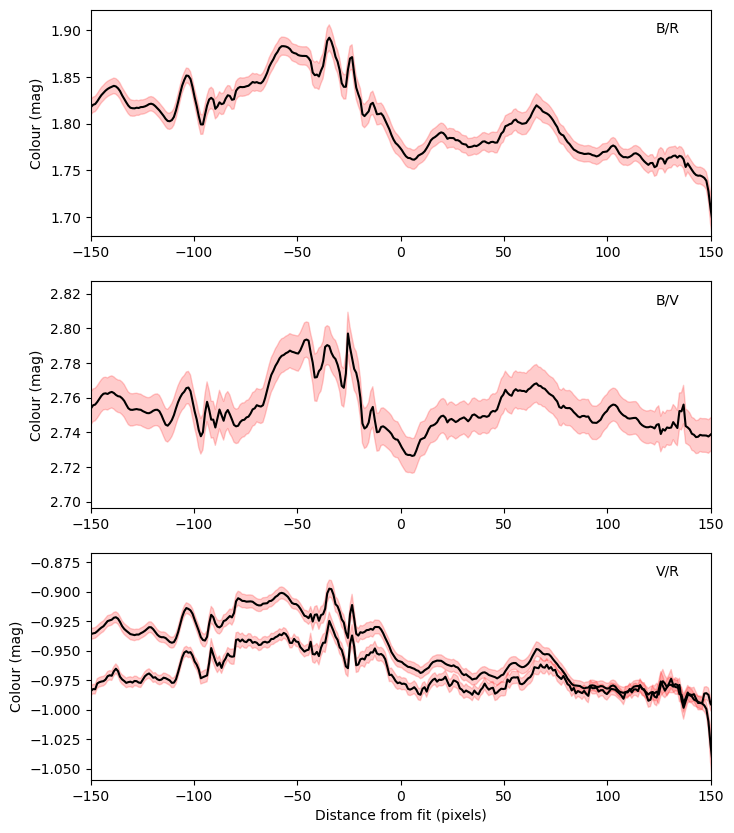

In [387]:
# Isolated

fig, axs = plt.subplots(3, 1, figsize=(8, 10))#, sharex=True)
ylimfix=0.03

# First subplot - B-R Colour Original Calibrated
#axs[0].set_title('B-R Colour Original Calibrated')
axs[0].set_ylabel('Colour (mag)')
axs[0].plot(distance, avg_intensity_BR_I, 'k')
axs[0].set_ylim(np.min(avg_intensity_BR_I[50:350]-ylimfix),np.max(avg_intensity_BR_I[50:350])+ylimfix)
axs[0].set_xlim(-150,150)
axs[0].fill_between(distance,avg_intensity_BR_I-uncertainty_BR_I,
                 avg_intensity_BR_I+uncertainty_BR_I ,alpha=0.2,color='red')
axs[0].text(0.95, 0.95, 'B/R', ha='right', va='top', transform=axs[0].transAxes)



# Second subplot - B-V Colour Original Calibrated
axs[1].set_ylabel('Colour (mag)')
axs[1].plot(distance, avg_intensity_BV_I, 'k')
axs[1].set_ylim(np.min(avg_intensity_BV_I[50:350]-ylimfix),np.max(avg_intensity_BV_I[50:350])+ylimfix)
axs[1].set_xlim(-150,150)
axs[1].fill_between(distance,avg_intensity_BV_I-uncertainty_BV_I,
                 avg_intensity_BV_I+uncertainty_BV_I  ,alpha=0.2,color='red')
axs[1].text(0.95, 0.95, 'B/V', ha='right', va='top', transform=axs[1].transAxes)


# Third subplot - V-R Colour Original Calibrated
axs[2].set_xlabel('Distance from fit (pixels)')
axs[2].set_ylabel('Colour (mag)')
axs[2].set_ylim(np.min(avg_intensity_VR_I[50:350]-ylimfix),np.max(avg_intensity_VR_I[50:350])+ylimfix)
axs[2].plot(distance, avg_intensity_VR_I, 'k')
axs[2].text(0.95, 0.95, 'V/R', ha='right', va='top', transform=axs[2].transAxes)

axs[2].set_xlim(-150,150)
axs[2].fill_between(distance,avg_intensity_VR_I-uncertainty_VR_I,avg_intensity_VR_I+uncertainty_VR_I,alpha=0.2,color='red')
axs[2].set_ylim(np.min(avg_intensity_VR_I[50:350]-ylimfix),np.max(avg_intensity_VR_I[50:350])+ylimfix)

axs[2].plot(distance, avg_intensity_VR, 'k')
axs[2].fill_between(distance,avg_intensity_VR-uncertainty_VR,
                 avg_intensity_VR+uncertainty_VR,alpha=0.2,color='red')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2)

#plt.xlim(-150, 150)

plt.show()

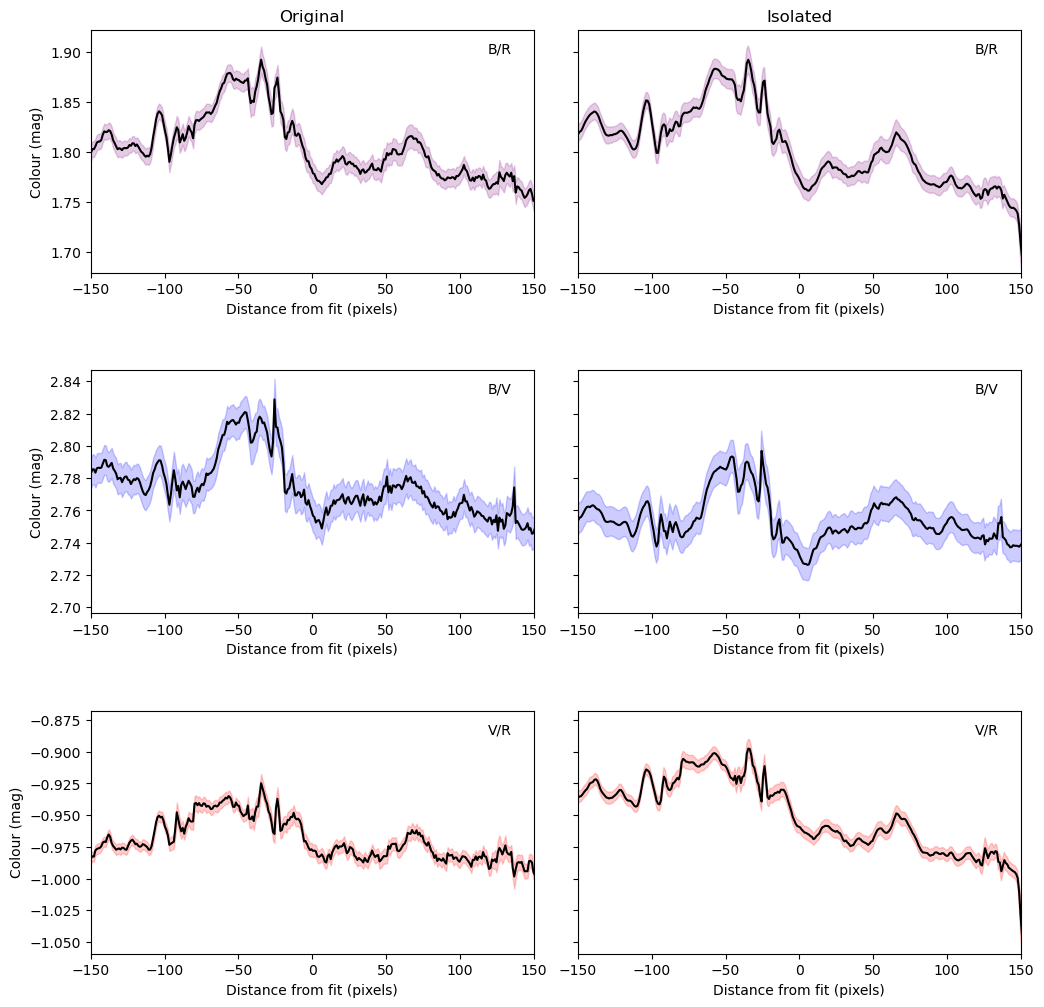

In [401]:
import matplotlib.pyplot as plt

# Create a figure with three subplots in two rows
fig, axs = plt.subplots(3, 2, figsize=(12, 12),sharey='row')

axs[0, 0].set_ylabel('Colour (mag)')
axs[0, 0].set_title('Original')
axs[0, 0].plot(distance, avg_intensity_BR, 'k')
axs[0, 0].fill_between(distance, avg_intensity_BR-uncertainty_BR,
                       avg_intensity_BR+uncertainty_BR, alpha=0.2, color='purple')
axs[0, 0].set_xlim(-150, 150)
axs[0, 0].set_xlabel('Distance from fit (pixels)')
axs[0, 0].text(0.95, 0.95, 'B/R', ha='right', va='top', transform=axs[0, 0].transAxes)


axs[1, 0].plot(distance, avg_intensity_BV, 'k')
axs[1, 0].set_ylabel('Colour (mag)')
axs[1, 0].fill_between(distance, avg_intensity_BV-uncertainty_BV,
                       avg_intensity_BV+uncertainty_BV, alpha=0.2, color='blue')
axs[1, 0].set_xlim(-150, 150)
axs[1, 0].set_xlabel('Distance from fit (pixels)')
axs[1, 0].text(0.95, 0.95, 'B/V', ha='right', va='top', transform=axs[1, 0].transAxes)


axs[2, 0].set_ylabel('Colour (mag)')
axs[2, 0].plot(distance, avg_intensity_VR, 'k')
axs[2, 0].fill_between(distance, avg_intensity_VR-uncertainty_VR,
                       avg_intensity_VR+uncertainty_VR, alpha=0.2, color='red')
axs[2, 0].text(0.95, 0.95, 'V/R', ha='right', va='top', transform=axs[2, 0].transAxes)
axs[2, 0].set_xlim(-150, 150)
axs[2, 0].set_xlabel('Distance from fit (pixels)')

#====================================================================================================================

axs[0, 1].set_title('Isolated')
axs[0, 1].plot(distance, avg_intensity_BR_I, 'k')
#axs[0, 1].set_ylabel('Colour (mag)')
axs[0, 1].fill_between(distance, avg_intensity_BR_I-uncertainty_BR_I,
                       avg_intensity_BR_I+uncertainty_BR_I, alpha=0.2, color='purple')
axs[0, 1].text(0.95, 0.95, 'B/R', ha='right', va='top', transform=axs[0, 1].transAxes)
axs[0, 1].set_xlim(-150, 150)
axs[0, 1].set_ylim(np.min(avg_intensity_BR_I[50:350])-ylimfix,np.max(avg_intensity_BR_I[50:350])+ylimfix)
axs[0, 1].set_xlabel('Distance from fit (pixels)')



#axs[1, 1].set_ylabel('Colour (mag)')
axs[1, 1].plot(distance, avg_intensity_BV_I, 'k')
axs[1, 1].fill_between(distance, avg_intensity_BV_I-uncertainty_BV_I,
                       avg_intensity_BV_I+uncertainty_BV_I, alpha=0.2, color='blue')
axs[1, 1].text(0.95, 0.95, 'B/V', ha='right', va='top', transform=axs[1, 1].transAxes)
axs[1, 1].set_xlim(-150, 150)
axs[1, 1].set_ylim(np.min(avg_intensity_BV_I[50:350]-ylimfix),np.max(avg_intensity_BV_I[50:350])+ylimfix+0.02)
axs[1, 1].set_xlabel('Distance from fit (pixels)')



axs[2, 1].plot(distance, avg_intensity_VR_I, 'k')
#axs[2, 1].set_ylabel('Colour (mag)')
axs[2, 1].fill_between(distance, avg_intensity_VR_I-uncertainty_VR_I,
                       avg_intensity_VR_I+uncertainty_VR_I, alpha=0.2, color='red')
axs[2, 1].text(0.95, 0.95, 'V/R', ha='right', va='top', transform=axs[2, 1].transAxes)
axs[2, 1].set_xlim(-150, 150)
axs[2, 1].set_xlabel('Distance from fit (pixels)')
axs[2, 1].set_ylim(np.min(avg_intensity_VR_I[50:350]-ylimfix),np.max(avg_intensity_VR_I[50:350])+ylimfix)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.1)

plt.show()
